# Exploratory Data Analysis 


In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

### Label Distribution for Fake and Real reviews

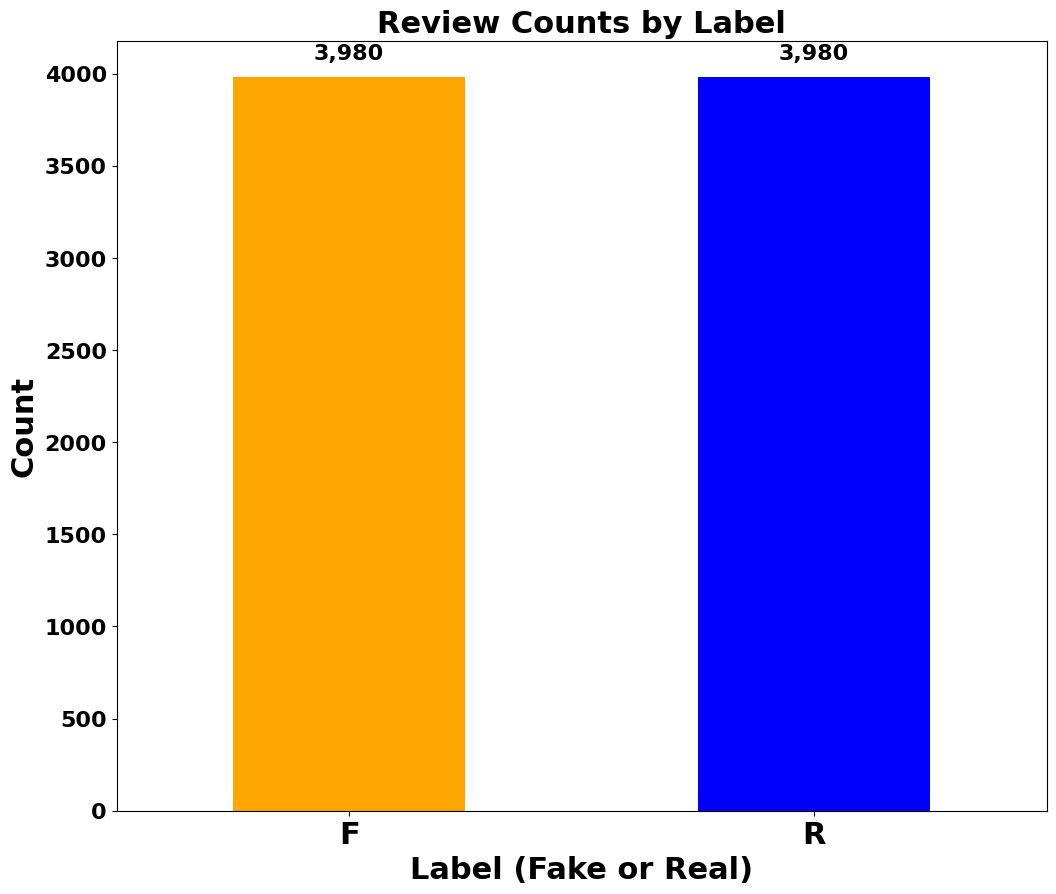

In [3]:
# Load the dataset
df = pd.read_csv("modified_dataset.csv")

# Count the number of reviews for each label
label_counts = df['LABEL'].value_counts()

# Update font sizes and make fonts bold for better readability
plt.rcParams.update({'font.size': 16, 'font.weight': 'bold'})  

# Plot the bar chart
plt.figure(figsize=(12, 10)) 
bars = label_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title('Review Counts by Label', fontsize=22, weight='bold')  
plt.xlabel('Label (Fake or Real)', fontsize=22, weight='bold')  
plt.ylabel('Count', fontsize=22, weight='bold')  
plt.xticks(rotation=0, fontsize=22, weight='bold') 
plt.yticks(fontsize=16, weight='bold')  

# Annotate the bars with the count values
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), ','),
                  xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  xytext=(0, 10), 
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=16, weight='bold')  

plt.show()


### Generating Box Plots and Bar Charts for Feature Analysis

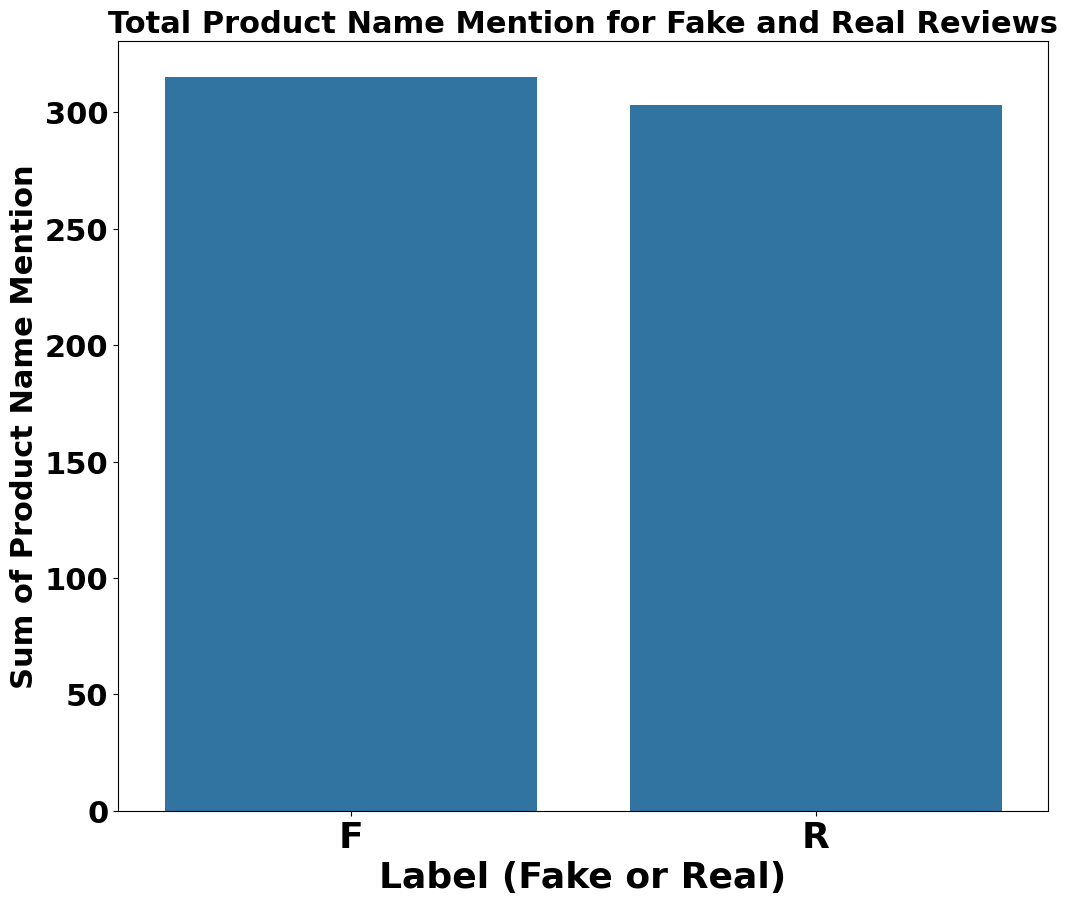

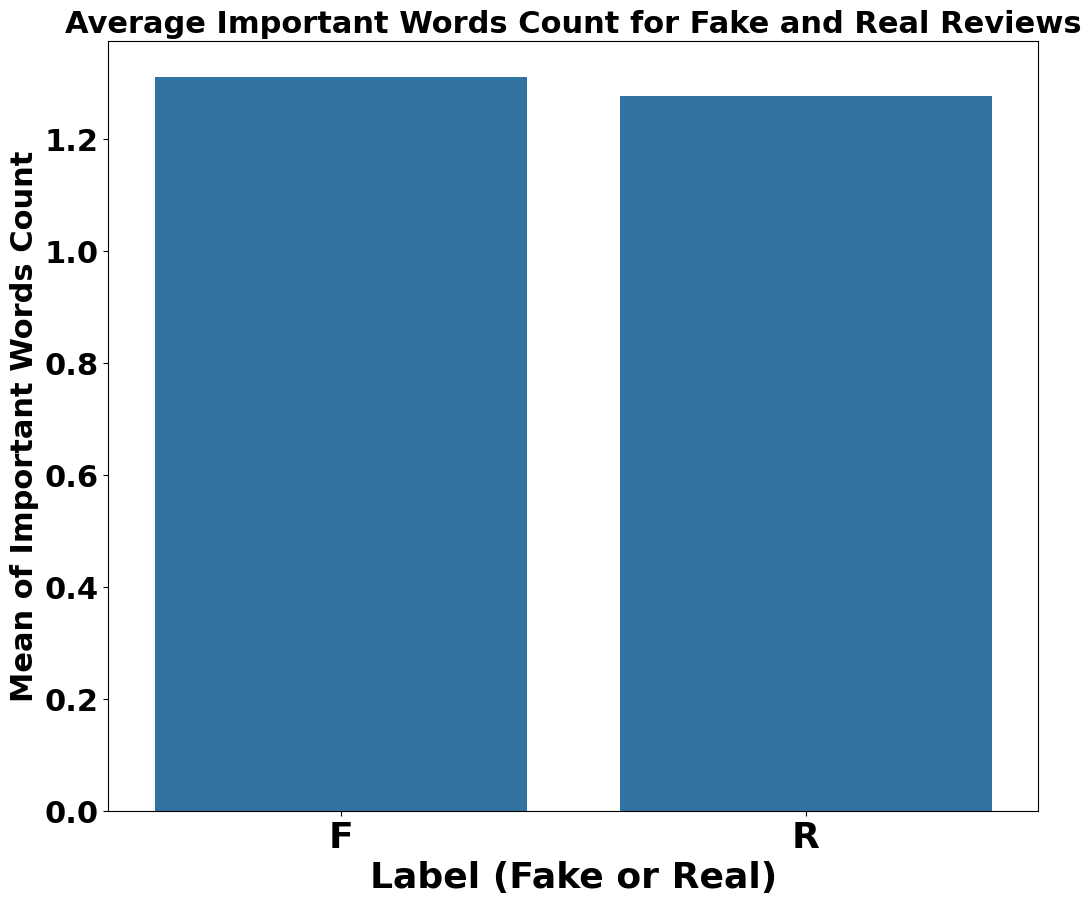

In [4]:
# Map 'Y' and 'N' to 1 and 0 in 'PRODUCT_NAME_MENTION'
df['PRODUCT_NAME_MENTION'] = df['PRODUCT_NAME_MENTION'].map({'Y': 1, 'N': 0})

# Function to create a bar chart for a given feature
def plot_bar_chart_for_feature(column_name, title, aggregation='sum'):
    # Group by LABEL and calculate the specified aggregation for the feature
    if aggregation == 'sum':
        feature_aggregation = df.groupby('LABEL')[column_name].sum().reset_index()
    elif aggregation == 'mean':
        feature_aggregation = df.groupby('LABEL')[column_name].mean().reset_index()
    
    # Update font sizes and make fonts bold for better readability
    plt.rcParams.update({'font.size': 22, 'font.weight': 'bold'}) 
    
    # Create the bar plot
    plt.figure(figsize=(12, 10))  
    sns.barplot(x='LABEL', y=column_name, data=feature_aggregation)
    plt.title(title, fontsize=22, weight='bold') 
    plt.ylabel(f'{aggregation.title()} of {column_name.replace("_", " ").title()}', fontsize=22, weight='bold')  
    plt.xlabel('Label (Fake or Real)', fontsize=26, weight='bold')  
    plt.xticks(rotation=0, fontsize=26, weight='bold')  
    plt.yticks(fontsize=22, weight='bold') 
    plt.show()

# Execute the plotting function for PRODUCT_NAME_MENTION with sum aggregation
plot_bar_chart_for_feature('PRODUCT_NAME_MENTION', 'Total Product Name Mention for Fake and Real Reviews', aggregation='sum')

# Execute the plotting function for IMPORTANT_WORDS_COUNT with mean aggregation
plot_bar_chart_for_feature('IMPORTANT_WORDS_COUNT', 'Average Important Words Count for Fake and Real Reviews', aggregation='mean')


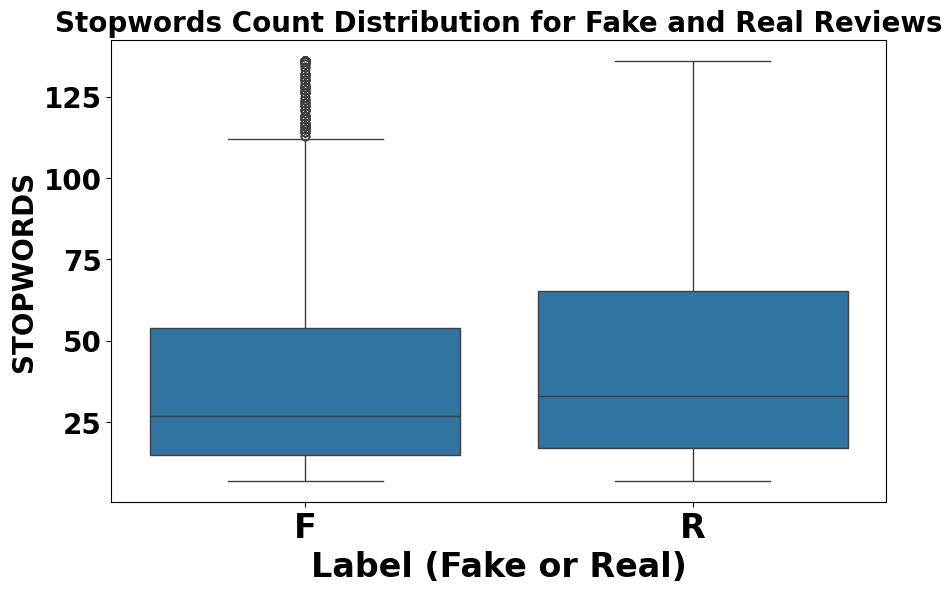

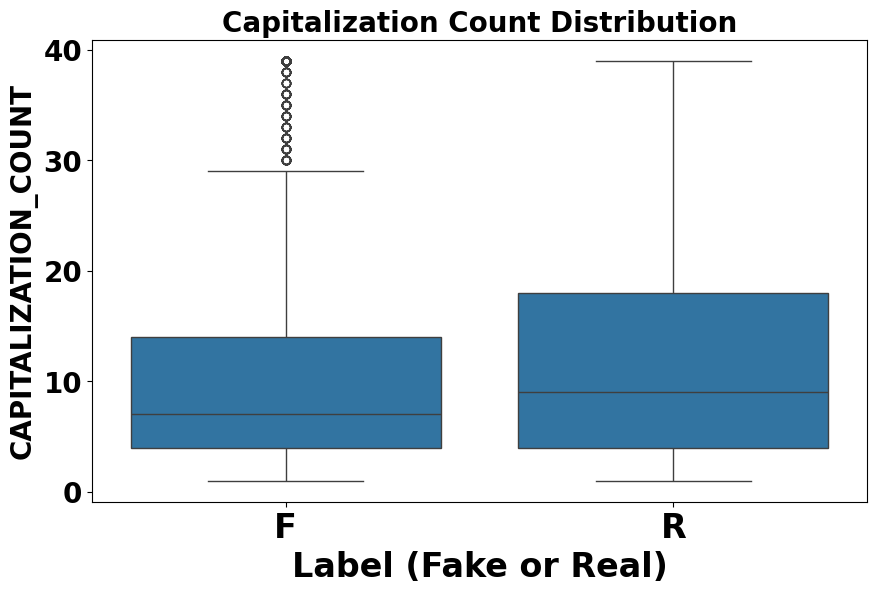

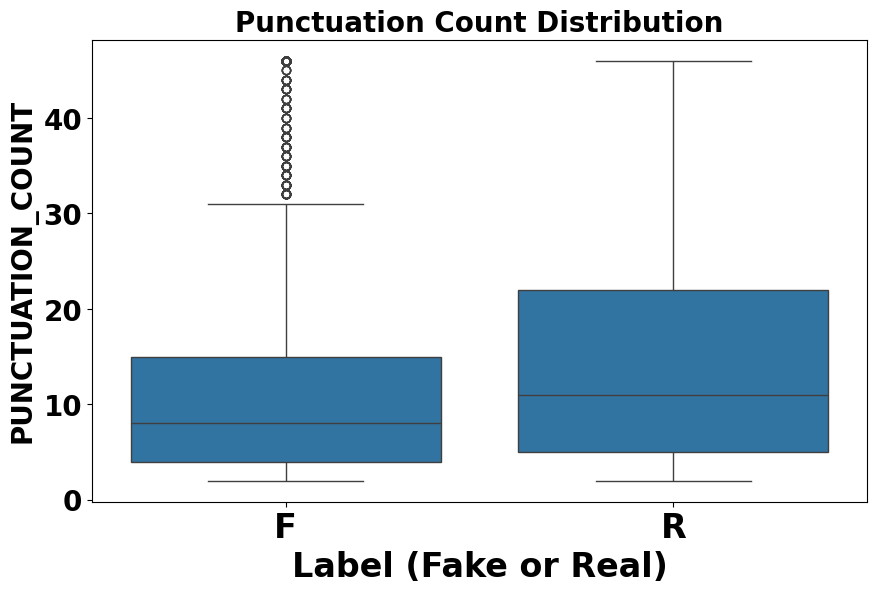

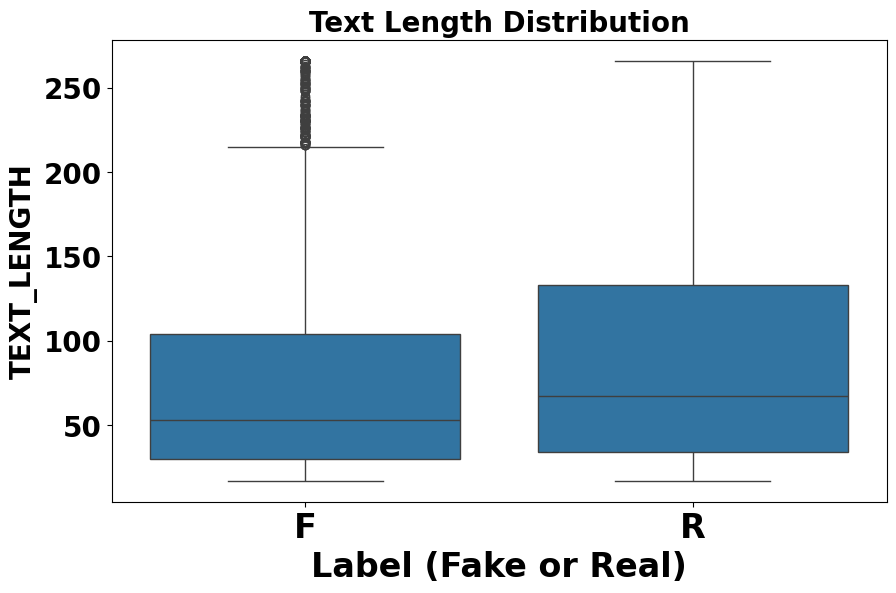

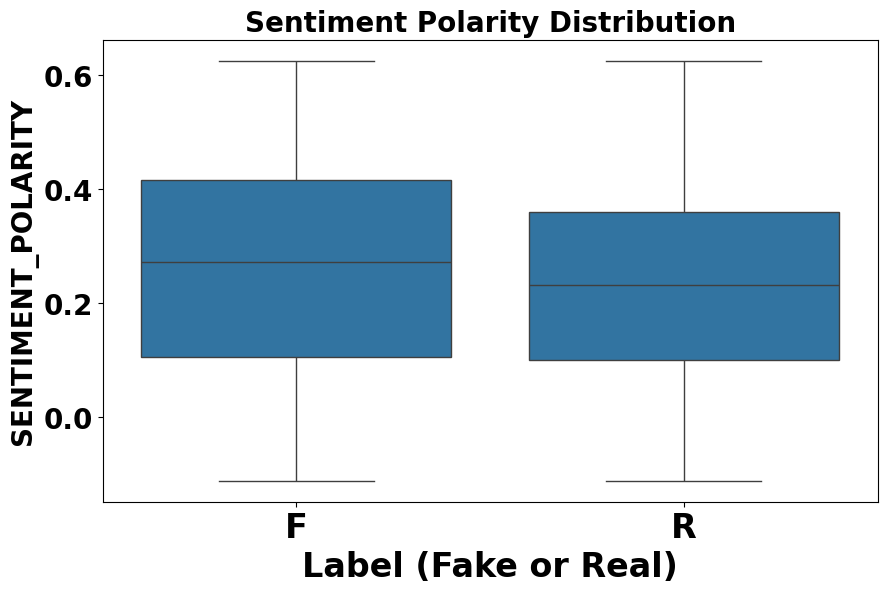

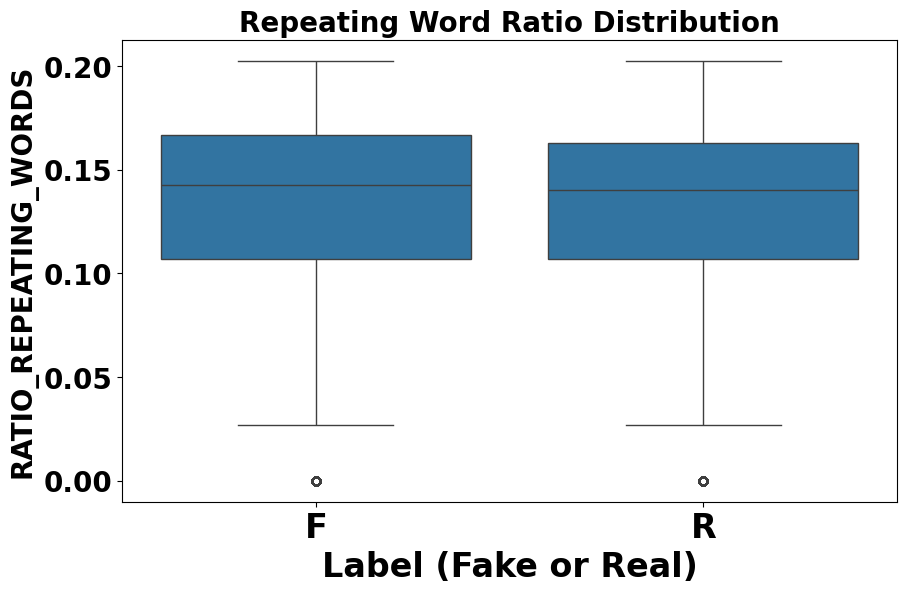

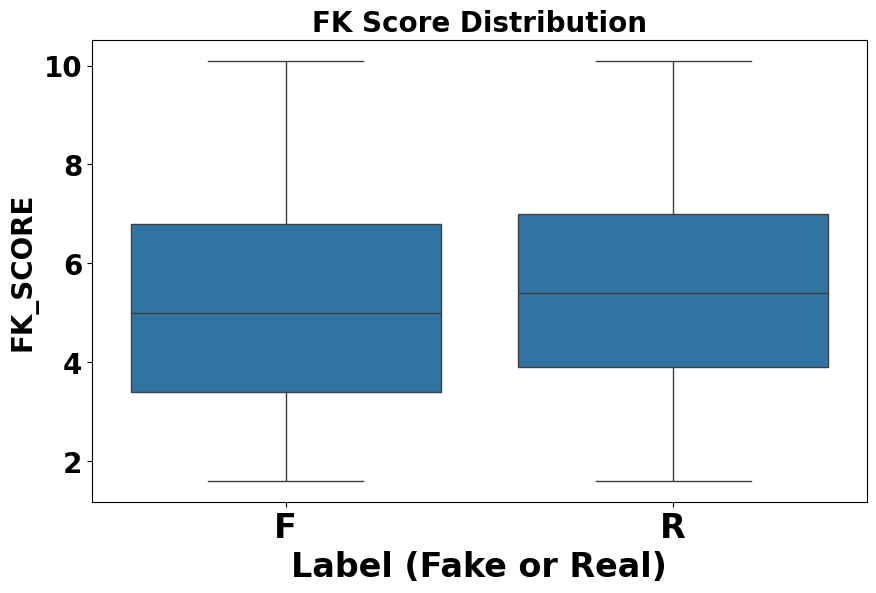

In [6]:
# Function to prepare data, remove outliers, and plot box plots
def plot_box_plot_for_column(column_name, title):
    # Remove outliers by clipping to the 5th and 95th percentiles
    lower_percentile = df[column_name].quantile(0.05)
    upper_percentile = df[column_name].quantile(0.95)
    df[column_name] = df[column_name].clip(lower=lower_percentile, upper=upper_percentile)
    
    # Generate box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='LABEL', y=column_name, data=df)
    plt.title(title, fontsize=20, weight='bold')
    plt.ylabel(column_name, fontsize=20, weight='bold')
    plt.xlabel('Label (Fake or Real)', fontsize=24, weight='bold')
    plt.xticks(fontsize=24, weight='bold')
    plt.yticks(fontsize=20, weight='bold')
    plt.show()

# List of columns and their corresponding plot titles
columns_to_plot = [
    ('STOPWORDS', 'Stopwords Count Distribution for Fake and Real Reviews'),
    ('CAPITALIZATION_COUNT', 'Capitalization Count Distribution'),
    ('PUNCTUATION_COUNT', 'Punctuation Count Distribution'),
    ('TEXT_LENGTH', 'Text Length Distribution'),
    ('SENTIMENT_POLARITY', 'Sentiment Polarity Distribution'),
    ('RATIO_REPEATING_WORDS', 'Repeating Word Ratio Distribution'),
    ('FK_SCORE', 'FK Score Distribution'),
]

# Execute plotting function for each specified column
for column, title in columns_to_plot:
    plot_box_plot_for_column(column, title)


### Distribution of Rating for Fake and Real Reviews

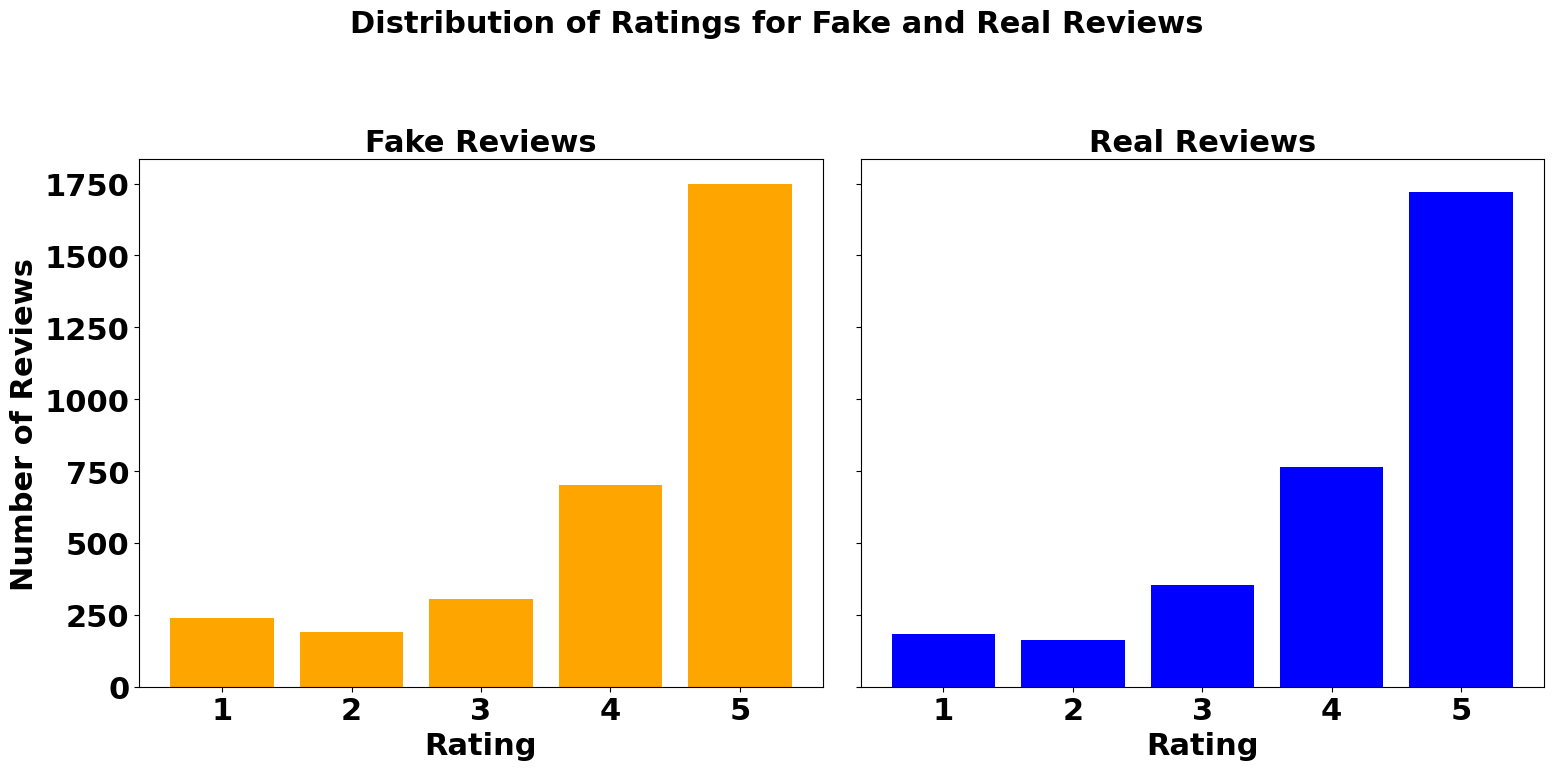

In [8]:
# Filter the dataset into fake and real reviews
fake_reviews = df[df['LABEL'] == 'F']
real_reviews = df[df['LABEL'] == 'R']

# Setting up the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
fig.suptitle('Distribution of Ratings for Fake and Real Reviews', fontsize=22, weight='bold')

# Update font sizes and make fonts bold for better readability
plt.rcParams.update({'font.size': 22, 'font.weight': 'bold'})  

# Plotting the histogram for fake reviews
axs[0].hist(fake_reviews['RATING'], bins=[1, 2, 3, 4, 5, 6], align='left', color='orange', rwidth=0.8)
axs[0].set_title('Fake Reviews', fontsize=22, weight='bold') 
axs[0].set_xlabel('Rating', fontsize=22, weight='bold')  
axs[0].set_ylabel('Number of Reviews', fontsize=22, weight='bold')  
axs[0].set_xticks(range(1, 6))
axs[0].tick_params(axis='x', labelsize=22)
axs[0].tick_params(axis='y', labelsize=22)

# Plotting the histogram for real reviews
axs[1].hist(real_reviews['RATING'], bins=[1, 2, 3, 4, 5, 6], align='left', color='blue', rwidth=0.8)
axs[1].set_title('Real Reviews', fontsize=22, weight='bold') 
axs[1].set_xlabel('Rating', fontsize=22, weight='bold')  
axs[1].set_xticks(range(1, 6))
axs[1].tick_params(axis='x', labelsize=22)
axs[1].tick_params(axis='y', labelsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Word Clouds for Fake and Real Reviews

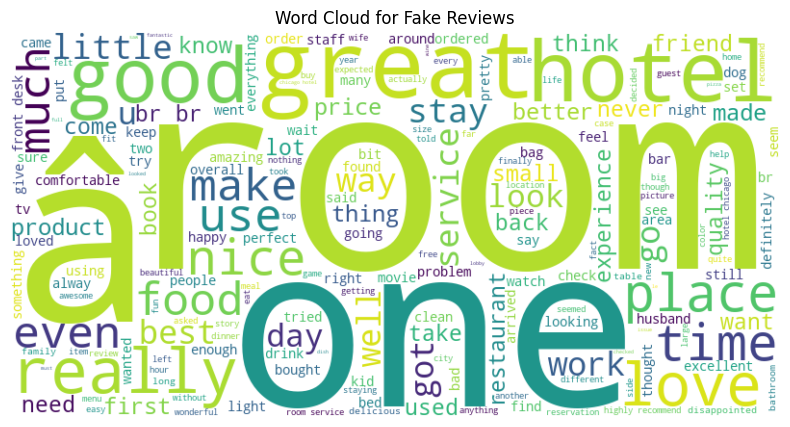

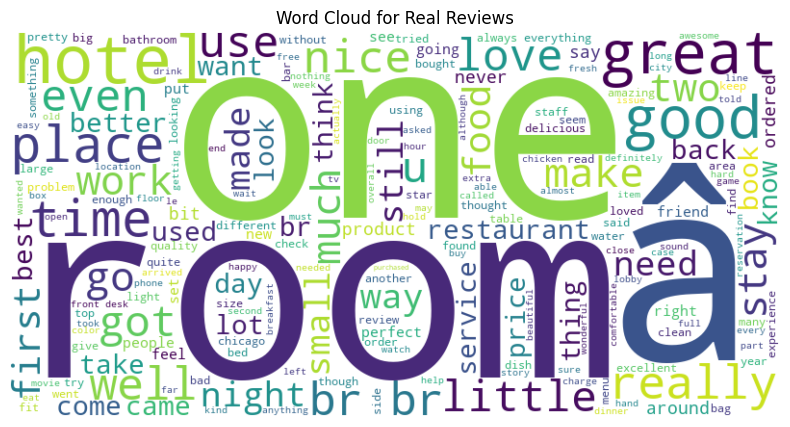

In [2]:
# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

# Apply text preprocessing
df['REVIEW_TEXT'] = df['REVIEW_TEXT'].apply(preprocess_text)

# Separate fake and real reviews
fake_reviews = df[df['LABEL'] == 'F']
real_reviews = df[df['LABEL'] == 'R']

# Combine all fake reviews into a single string
all_fake_reviews = ' '.join(fake_reviews['REVIEW_TEXT'])

# Combine all real reviews into a single string
all_real_reviews = ' '.join(real_reviews['REVIEW_TEXT'])

# Generate the word cloud for fake reviews
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(all_fake_reviews)

# Generate the word cloud for real reviews
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(all_real_reviews)

# Display the word cloud for fake reviews
plt.figure(figsize=(10, 5))
plt.title('Word Cloud for Fake Reviews')
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()

# Display the word cloud for real reviews
plt.figure(figsize=(10, 5))
plt.title('Word Cloud for Real Reviews')
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()
